In [102]:
import datetime
import time

# Import libraries use for visualization and analysis
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import cufflinks as cf

# Import the Monasca and Keystone clients
from monascaclient import client
from monascaclient import ksclient

from pandas import Series,DataFrame

# Import library to execute remote commands for monasca-agent demo
import spur
import matplotlib.pyplot as plt
import seaborn as sns

In [103]:
'''%export OS_PROJECT_NAME=mini-mon
%export OS_PASSWORD=password
%export OS_AUTH_URL=http://157.159.232.218:35357/v3/
%export OS_USERNAME=mini-mon
%export MONASCA_API_URL=http://157.159.232.217:8070/v2.0/'''
monasca_url = 'http://157.159.232.217:8070/v2.0/'

In [104]:
api_version = '2_0'

# Authenticate to Keystone
keystone_url = 'http://157.159.232.218:35357/v3/'
ks = ksclient.KSClient(auth_url=keystone_url, username='mini-mon', password='password')

# construct the mon client
monasca_client = client.Client(api_version, monasca_url, token=ks.token)
# call the metric-create command
'''
dimensions = {'instance_id': '12345', 'service': 'hello'}
fields = {}
fields['name'] = 'cindy1'
fields['dimensions'] = dimensions
fields['timestamp'] = time.time()
fields['value'] = 222.333'''


"\ndimensions = {'instance_id': '12345', 'service': 'hello'}\nfields = {}\nfields['name'] = 'cindy1'\nfields['dimensions'] = dimensions\nfields['timestamp'] = time.time()\nfields['value'] = 222.333"

In [105]:
'''try:
    resp = monasca_client.metrics.list();   
except exc.HTTPException as he:
    print(he.code)
    print(he.message)
else:
    print(resp)'''

'try:\n    resp = monasca_client.metrics.list();   \nexcept exc.HTTPException as he:\n    print(he.code)\n    print(he.message)\nelse:\n    print(resp)'

In [106]:
#monasca_client.metrics.list_measurements('2014-01-01T00:00:00Z');

In [6]:
shell = spur.SshShell(hostname='157.159.232.217',username='ubuntu',missing_host_key=spur.ssh.MissingHostKey.accept,private_key_file='/home/jaafar/Downloads/ici.pem');

In [7]:
# for testing
T = shell.run(["ifconfig"])

In [8]:
#T = shell.run(["monasca","measurement-list","cpu.user_perc", "2016-05-20T15:52:26.0C"])

In [9]:
#result = shell.run(["export", "OS_PROJECT_NAME=mini-mon"])#,["export", "OS_PASSWORD=password"],["export", "OS_AUTH_URL=http://157.159.232.218:35357/v3"],["export", "OS_USERNAME=mini-mon"])#
print(result.output) # prints hello

NameError: name 'result' is not defined

In [107]:
#result = shell.run(["monasca","metric-list"])
#print(result.output) # prints hello

In [108]:
# sync clock
# shell.run(['sudo', 'ntpdate', 'time.nist.gov'])

In [109]:
def get_metrics(names=[None], dimensions={}, limit=10):
    metrics = []
    for name in names:        
        # Invoke the Monasca client
        metrics = metrics + monasca_client.metrics.list(name=name, dimensions=dimensions, limit=limit)
    return metrics

In [110]:
def get_measurements(metrics, start_time = None, end_time = None, limit=None):
    measurements = []
    
    if start_time == None:
        start_date = datetime.datetime.utcnow() - datetime.timedelta(seconds=3600)
        start_time = start_date.strftime("%Y-%m-%dT%H:%M:%SZ")

    if end_time == None:
        end_date = datetime.datetime.utcnow() - datetime.timedelta(seconds=0)
        end_time = end_date.strftime("%Y-%m-%dT%H:%M:%SZ")
        
    for metric in metrics:        
        # Invoke the Monasca client
        measurements.append(monasca_client.metrics.list_measurements(
                name=metric['name'],
                dimensions=metric['dimensions'],
                start_time=start_time,
                end_time=end_time))
        
    return measurements

In [111]:
def df_from_measurements(measurements, group_by=[]):
    '''Returns a DataFrame given measurements'''
    measurement = measurements[1]
    m = np.array(measurement[0]['measurements'])  
    timestamps = m[:, measurement[0]['columns'].index('timestamp')]
    df = pd.DataFrame(index = timestamps)  
    
    for measurement in measurements:
        if measurement:
            measure = measurement
            m = np.array(measure[0]['measurements'])
            name = measure[0]['name']
            dimensions = measure[0]['dimensions']
        
            for group in group_by:
                if group in dimensions:
                    name += '.' + dimensions[group]
            #df[name] = m[:measure[1][0]['columns'].index('value')]     
    return df



In [113]:
metrics = get_metrics(names=['net.out_packets_sec'])
measurements = get_measurements(metrics,"2016-05-10T15:52:26.0Z","2016-05-20T15:55:26.0Z")

In [114]:
i = 0;
max = len(measurements);
for measure in measurements:
    if measure:
       
        data = np.array(measure[0]['measurements'])
        metric_name = measure[0]['name']
        hostname = measure[0]['dimensions'].get('hostname')
        service = measure[0]['dimensions'].get('service')
        timestamp = ["" for x in range(len(data))] 
        values = np.zeros(len(data))
        i = i + 1;
        i=0;
        if hostname == "mini-mon" and metric_name == "net.out_packets_sec":
            for d in data:
                timestamp[i] = d[0]
                values[i] = d[1]
                i = i + 1
            df = pd.DataFrame(index = timestamp)
            df['name'] = metric_name
            df[service] = service
            df[hostname] = hostname
            df['valeur'] = values
            df['time'] = np.arange(len(timestamp))

In [115]:
metrics;

In [116]:
df;

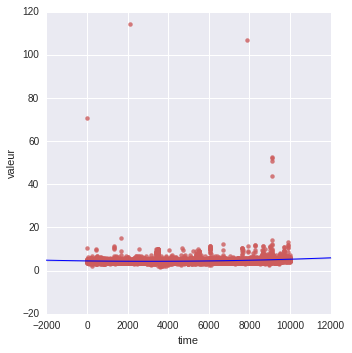

In [186]:
sns.lmplot('time','valeur',df,order=2,scatter_kws={'marker':'o','color':'indianred'},line_kws={'linewidth':1,'color':'blue'})

## Start from Here the Evaluation

In [1368]:
import math
from __future__ import division
# test 
Z = np.arange(100)
i = 0;
X = np.zeros(x.size)
for a in Z:
    X[i] = math.sin(a)
    i = i + 1;
X;

In [1410]:
v = np.asarray(df.valeur)

a = 200
X = v[1:a]
#X = X_mean[1:20];
df_slice = df[1:a];
df_slice;
X_mean = np.asarray(pd.rolling_mean(df_slice['valeur'],3))

In [1411]:
def autocorr(x):
    result = np.correlate(x,x,mode='full')
    return result[result.size/2]

In [1412]:
autocorr(X)

/home/jaafar/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: DeprecationWarning:

using a non-integer number instead of an integer will result in an error in the future



4009.6830729166659

In [1413]:
def write_to_csv(filename,df): 
    dframe = DataFrame(df,columns=['valeur'])
    dframe.to_csv(filename,sep=';',index=False,header=None)

In [1414]:
write_to_csv('jaafar.csv',df)

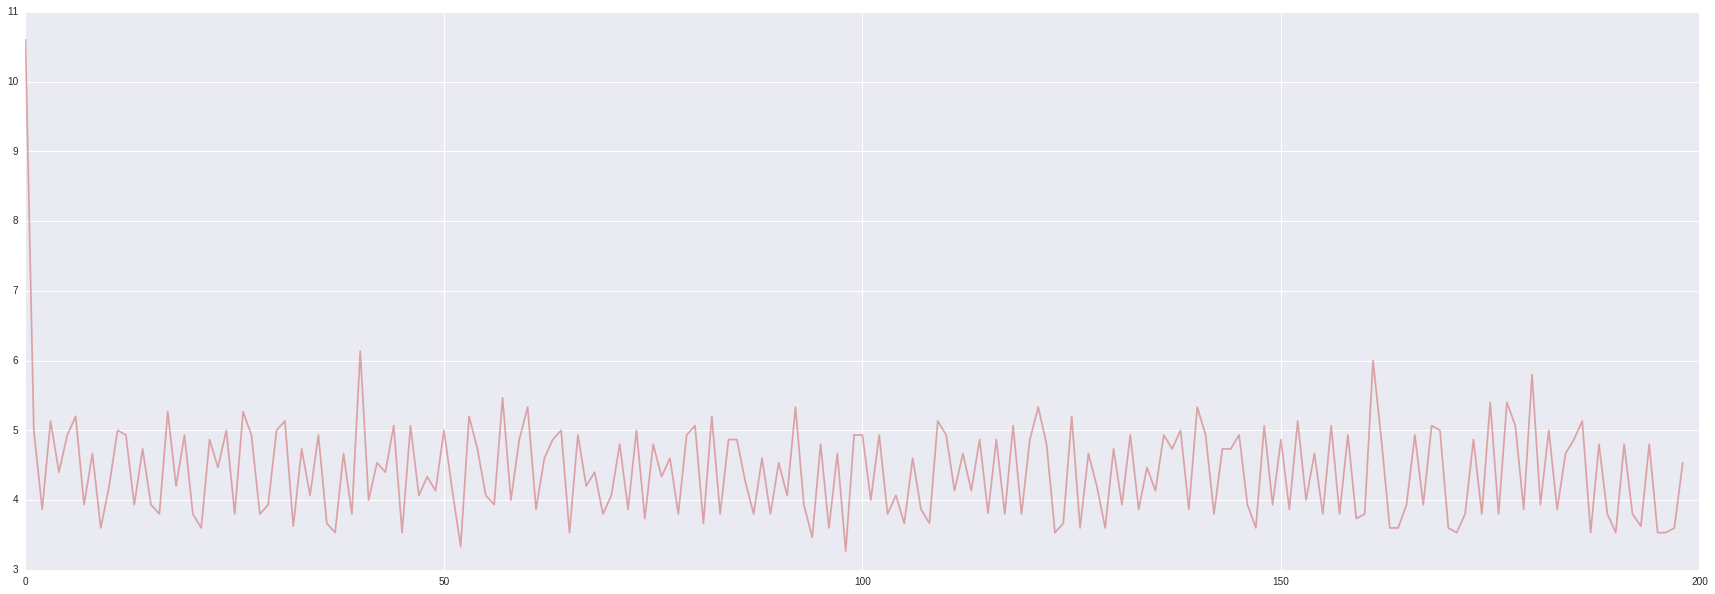

In [1415]:
# Plot the selected sub range in function of time 
tmps =np.arange(X.size)
plt.subplots(figsize=(30, 10))
plt.plot(tmps,X,color='indianred',alpha=0.5)

/home/jaafar/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



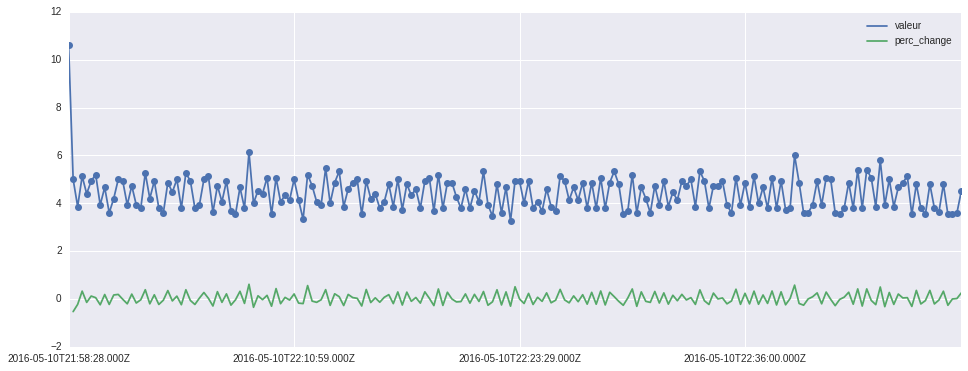

In [1416]:

# We'll use pct_change to find the percent change for each day
df_slice['perc_change'] = df_slice['valeur'].pct_change()
# Then we'll plot the daily return percentage
df_slice['valeur'].plot(figsize=(16,6),legend=True,linestyle='-',marker='o')

df_slice['perc_change'].plot(figsize=(16,6),legend=True,linestyle='-',marker='x')



In [1417]:
#X = perc_change;

#X = X[~np.isnan(X)]
X;

In [1418]:
ma_pt = [2,10]

for ma in ma_pt:
    column_name = "MA for %s datapoint" %(str(ma))
    df_slice[column_name]=pd.rolling_mean(df_slice['valeur'],ma)


/home/jaafar/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fe54173a3d0>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7fe542964190>], dtype=object)

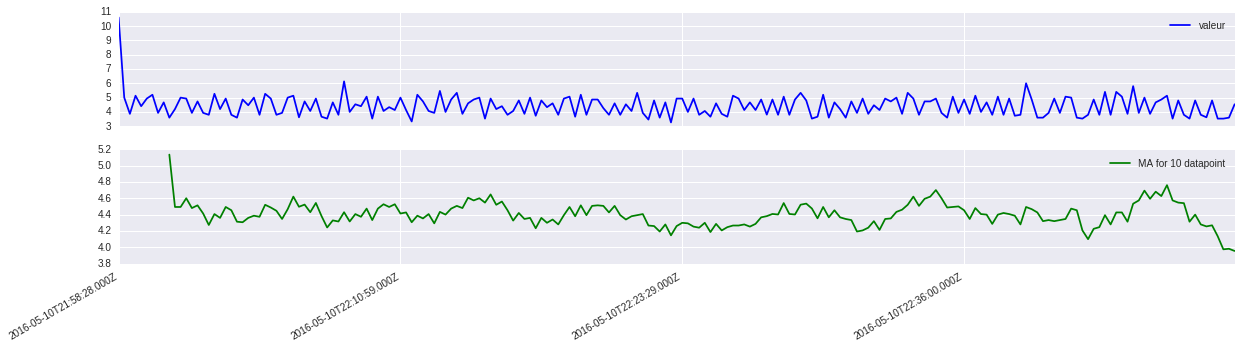

In [1419]:
df_slice[['valeur','MA for 10 datapoint']].plot(subplots=True,figsize=(20,5),)

In [1420]:
def normalize(X):
        return X/X.sum()
    
''' xmin = X.min()
    xmax = X.max()
    x2 = X.copy()
    x2 -= xmin
    x2 /= (xmax-xmin)
    return x2,(xmax-xmin),xmin'''

def rolling_avg(X,m):
    mean = np.asarray(pd.rolling_mean(df_slice['valeur'],m))
    return mean[~np.isnan(mean)]

def percentage_change(X):
    return [100.0 * a1/a2 - 100 for a1, a2 in zip(X[1:], X)]
    


In [1421]:
a=[10,20,25,50]
zip(a[1:],a)

[(20, 10), (25, 20), (50, 25)]

In [1422]:
#[X_norm,normx,normy] = normalize(X)
X_norm = normalize(X)
X_perc = percentage_change(X)
X_rol_avg = rolling_avg(X,3)
X_norm.sum()

1.0

In [1423]:
# send norm to jaafar.csv    
'''xx = DataFrame(d,X_norm,columns=['norm']) 
dframe = DataFrame(xx,columns=['norm'])
dframe.to_csv('jaafar.csv',sep=';',index=False,header=None)
'''
X;

In [1424]:
def structure_data(X,window,sel):
    if sel == 0:
        y = X[window:]
        y_l = [ [y[i]] for i in range(y.size) ]
        X_input =  np.resize(X,(X.size/window,window))
        X_l = X_input.tolist()
        return X_l,y_l,y
    else:
        y = X[step_size:]
        y_l = [ [y[i]] for i in range(y.size) ]
        X = X[:-step_size]
        X_l = [ [X[i]] for i in range(X.size) ]
        return X_l,y_l,y


In [1425]:
window = 1
step_size = 2
[X_vect,y_vect,y_arr] = structure_data(X_norm,window,1)

In [1643]:
from ann import ANN

# 4 input neurons
# 10 hidden neurons
# 3 output neurons: 
nn = ANN([window,10,20,1], activation_fun='linear')


# Here please Try to represent the input data as percentage so that you can capture patterns

# train the ANN
#nn.train(inputs, targets, 1600)
nn.train(X_vect,y_vect,1000)

(0, 0.033908954826521238)
(100, 5.7977741984548459e-05)
(200, 5.7976330829788994e-05)
(300, 5.7975020802159786e-05)
(400, 5.7973717016423715e-05)
(500, 5.7972419478478672e-05)
(600, 5.7970963069466368e-05)
(700, 5.7968891834317033e-05)
(800, 5.7966315262732485e-05)
(900, 5.7963203906346344e-05)


In [1694]:
h;

In [1691]:
def get_prediction(Xi,norm):
    if norm == 0:
        return [ nn.predict(X[i])[0]*normx+normy for i in range(len(X))]
    else:
        return [ Xi[i] + nn.predict([Xi[i]])[0]*Xi[i] for i in range(len(Xi))]

In [1692]:
h = get_prediction(X,1)

In [1429]:
def unnorm(y_arr2):
    y_arr3 = np.zeros(y_arr2.size)
    for i in range(y_arr2.size):
        y_arr3[i] = y_arr2[i] * normx+normy 
    return y_arr3

In [1484]:
#y_arr_N = unnorm(y_arr)
h_N = h*normx+normy 

/home/jaafar/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: DeprecationWarning:

using a non-integer number instead of an integer will result in an error in the future



In [1647]:
y_arr = np.asanyarray(y_vect)
h_arr = np.asanyarray(h)
error = (y_arr - y_arr)**2
y_arr;

In [1432]:
def plot(x,y,points):
    plt.subplots(figsize=(30, 10))
    tmps = np.arange(points)
    plt.plot(tmps,x[:points],'r--')
    plt.plot(tmps,y[:points],'b-')

def recadrer(h,window):
    h_out = np.zeros(len(h)+window)
    i=0;
    for i in range(h_out.size):
        if i >= window:
            h_out[i] = h[i-window][0]
        else:
            h_out[i] = 0
    return h_out

In [ ]:
ha = h_arr

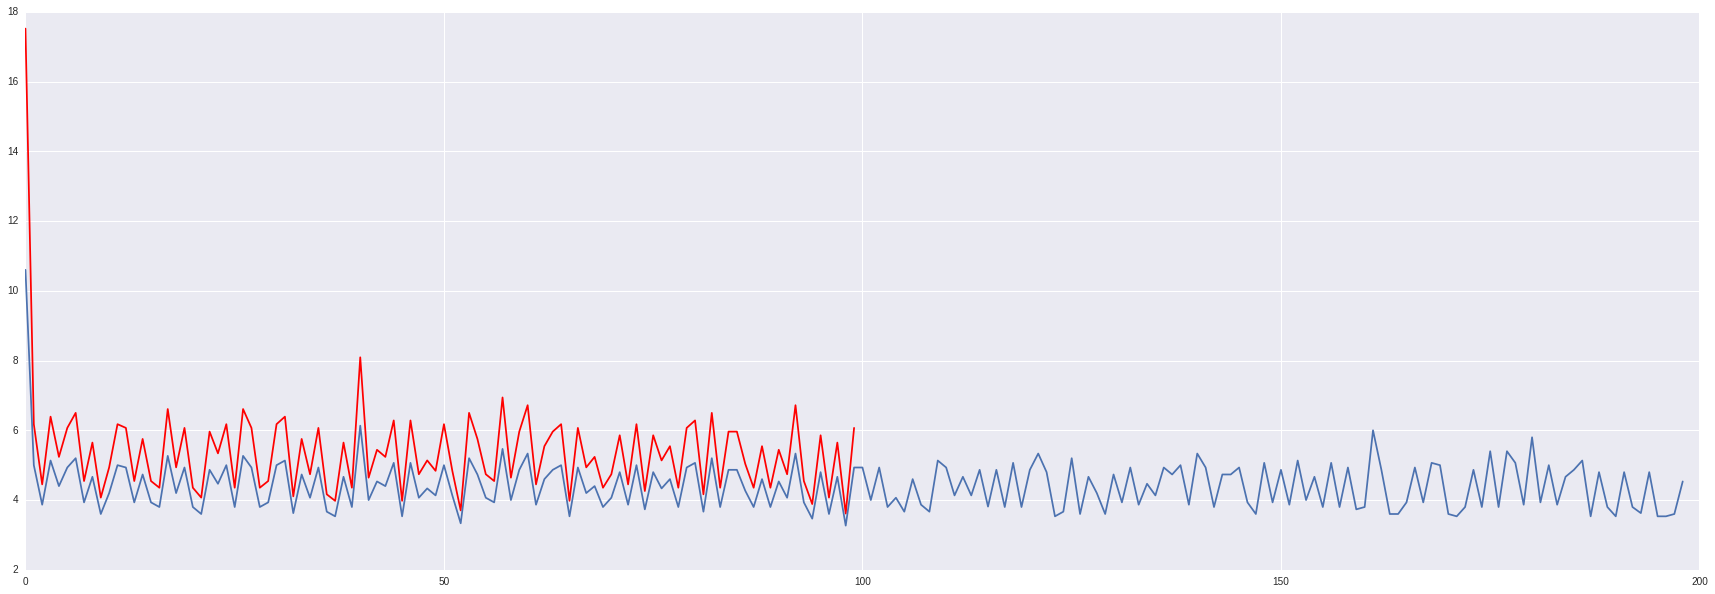

In [1700]:
'''X_mean = np.asarray(pd.rolling_mean(df_slice['valeur'],5))
y_arr_N;'''

#h_out = recadrer(h,window);

#plot(h,y_vect,100);

tmps = np.arange(100)
plt.subplots(figsize=(30, 10))
plt.plot(tmps,h[0:100],'r-',X)
#plt.plot(tmps,y_r[0:30],'b--')


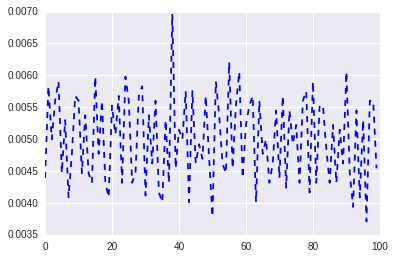

In [1698]:
plt.plot(tmps,y_vect[0:100],'b--')

In [1679]:
def reset_array(X1,Y1):
             #return Y1*((X1.max()-X1.min()))

In [1680]:
y_r = reset_array(h_arr,y_arr)


In [1641]:
nn.predict([X[27]])

[0.069644340628960674]

In [1367]:
h;

In [1366]:
h_out = np.zeros(len(h)+window)
for i in range(len(h)):
    if i >= window:
        h_out[i] = h[i]
    else:
        h_out[i] = 0
df_slice['time'] = np.arange(df_slice.time.size)


ValueError: setting an array element with a sequence.

In [ ]:
I = np.arange(h_out.size)
df2 = DataFrame(h_out,I,columns=['pred'])
df_resultat = pd.merge(df_slice,df2,right_index=True,left_on='time')#,left_on=True,right_on=True)
df_resultat;

In [ ]:
df_resultat[['valeur','pred']].plot(subplots=False,figsize=(20,10))

In [ ]:
h_out